In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [36]:
model_deepfake = keras.Sequential([
  layers.Conv2D(filters = 64, kernel_size = 4, strides = (1, 1), input_shape = (256, 256, 3), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters = 32, kernel_size = 4, strides = (1, 1), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters = 16, kernel_size = 4, strides = (1, 1), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(units = 4096, activation = 'relu'),
  layers.Dropout(rate = 0.1),
  layers.Dense(units = 256, activation = 'relu'), 
  layers.Dense(units = 1)
])

In [37]:
model_deepfake.compile(optimizer = SGD(lr=0.01), 
                       metrics = keras.metrics.BinaryAccuracy(),
                       loss = keras.losses.BinaryCrossentropy())

In [38]:
model_deepfake.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 64)      3136      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      32800     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        8208      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [5]:
# Create a second function to randomly select image data from a file
def get_images(n: int, dtype: str='train', seed: int=None):
    '''
    Returns n randomly selected testing, training, or validation data.
    
    Takes ~13 sec / 100 iter with n = 100
    Takes ~118 sec / 1000 iter with n = 100
    '''

    # Make sure train param is valid
    if dtype not in ['train', 'valid', 'test']:
        raise Exception("dtype argument must be train, valid, or test.")
    
    # Load labeled dataframes
    PATHDIR = Path('data')
    df = pd.read_csv(PATHDIR / f'{dtype}.csv', header = 0).drop(['original_path', 'Unnamed: 0', 'label_str'], axis=1)

    
    # Get the number of files in the directory of interest
    n_files = {"train": 50000, "valid": 10000, "test": 10000}[dtype]
    
    # Make sure you don't want more pictures than we have
    if n > n_files:
        raise Exception(f'There are not {n} files in the {dtype} folder')
    
    # Create the paths to the data
    datapath = Path('.') / 'data' / 'real_vs_fake' / 'real-vs-fake' / dtype
    fakepath = datapath / 'fake'
    realpath = datapath / 'real'
    
    # Set a seed if present
    if seed is not None:
        rn.seed(seed)
    
    # Get n random ids
    sample_ids = rn.choice(df['id'].to_numpy(), size=n)
    
    # Get the labels and image paths from the ids
    sample_df = df.copy()
    sample_df = sample_df[sample_df['id'].isin(sample_ids)]

    return sample_df

In [6]:
# Create a function to prepare random images for training
def prep_for_train(sample_df):
    """
    Gets the images from the get_image family of functions into a format
    that the model can understand.
    """
    # Save the labels
    y = sample_df['label'].to_numpy()

    # Path to the data
    DATADIR = Path('data/') / 'real_vs_fake'/ 'real-vs-fake'

    # Load the sample images
    n = sample_df.shape[0]
    X = np.empty(shape=(n, 256, 256, 3))

    # Load in the images to be trained on
    for img_idx, img_path in enumerate(sample_df['path']):
        img = plt.imread(DATADIR / img_path)
        # plt.imshow(img)
        # plt.show()
        X[img_idx, :, :, :] = img / 255.0

    return X, y[np.newaxis].reshape(-1, 1)
        

In [39]:
# TRAIN THAT MODEL!
X, y = prep_for_train(get_images(100, seed=69))
model_fit = model_deepfake.fit(X, y, epochs=5, batch_size=50, validation_data=prep_for_train(get_images(100, dtype='valid', seed=12)))

Epoch 1/5
2/2 [==============================] - 9s 6s/step - loss: 4.4048 - binary_accuracy: 0.5267 - val_loss: 7.3196 - val_binary_accuracy: 0.5200
Epoch 2/5
2/2 [==============================] - 10s 6s/step - loss: 6.5063 - binary_accuracy: 0.5733 - val_loss: 7.3196 - val_binary_accuracy: 0.5200
Epoch 3/5
2/2 [==============================] - 9s 6s/step - loss: 6.7097 - binary_accuracy: 0.5600 - val_loss: 7.3196 - val_binary_accuracy: 0.5200
Epoch 4/5
2/2 [==============================] - 9s 5s/step - loss: 6.7097 - binary_accuracy: 0.5600 - val_loss: 7.3196 - val_binary_accuracy: 0.5200
Epoch 5/5
2/2 [==============================] - 9s 5s/step - loss: 6.4047 - binary_accuracy: 0.5800 - val_loss: 7.3196 - val_binary_accuracy: 0.5200


In [40]:
model_fit.history

{'loss': [4.752274990081787,
  6.557172775268555,
  6.557172775268555,
  6.557172775268555,
  6.557172775268555],
 'binary_accuracy': [0.550000011920929,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426],
 'val_loss': [7.319634437561035,
  7.319634437561035,
  7.319634437561035,
  7.319634437561035,
  7.319634437561035],
 'val_binary_accuracy': [0.5199999809265137,
  0.5199999809265137,
  0.5199999809265137,
  0.5199999809265137,
  0.5199999809265137]}

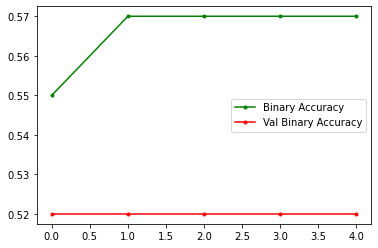

In [41]:
plt.plot(model_fit.history['binary_accuracy'], 'g.-', label = 'Binary Accuracy')
plt.plot(model_fit.history['val_binary_accuracy'], 'r.-', label = 'Val Binary Accuracy')
plt.legend()
plt.show()

In [20]:
model1 = model_fit

In [10]:
print(tf.__version__)

2.4.1


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12550747937090227957
]


In [8]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
|